### Set Up

In [477]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

In [478]:
# Función para convertir un archivo .parquet a .csv
def convertir_parquet_a_csv(ruta_parquet, ruta_csv):
    try:
        # Leer el archivo .parquet
        datos = pd.read_parquet(ruta_parquet)
        # Guardar el DataFrame en formato .csv
        datos.to_csv(ruta_csv, index=False)
        print(f"Archivo convertido y guardado en {ruta_csv}")
    except Exception as e:
        print(f"Error al convertir el archivo: {e}")

# Ruta del archivo .parquet en Google Drive y la ruta de salida para el .csv
ruta_parquet = './features_cleaned.parquet'  # Cambia esta ruta según la ubicación del archivo .parquet
ruta_csv = './features_cleaned.csv'         # Cambia esta ruta de salida para el archivo .csv

# Llamada a la función
convertir_parquet_a_csv(ruta_parquet, ruta_csv)

Archivo convertido y guardado en ./features_cleaned.csv


In [479]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np

# Ruta de los archivos en tu Drive
features_file = './features_cleaned.csv'
labels_file = './dfcrossmatches_prioritized_v7.0.1.csv'

# Cargar el archivo de características con 'oid' como índice
df_feat = pd.read_csv(features_file, index_col='oid')

# Cargar el archivo de etiquetas con 'oid' como índice
df_labels = pd.read_csv(labels_file, index_col='oid', on_bad_lines='skip')

# Verificar las columnas disponibles en df_labels
print("Columnas en df_labels:", df_labels.columns)

# Verificar si 'classALeRCE' existe en las columnas
if 'classALeRCE' in df_labels.columns:
    # Descartar valores infinitos en df_feat
    df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

    # Imprimir tamaño de la columna de clases y las primeras filas del DataFrame de características
    print(df_labels['classALeRCE'].values.size)
    print(df_feat.head())
else:
    print("La columna 'classALeRCE' no fue encontrada en df_labels.")
    print("Asegúrate de que el archivo tiene esta columna correctamente definida.")


Columnas en df_labels: Index(['classALeRCE', 'ra', 'dec', 'period', 'source', 'id_source',
       'class_source', 'separation_arcsec'],
      dtype='object')
173879
                  gal_b       gal_l  g-r_max_g_r  g-r_mean_g_r  \
oid                                                              
ZTF18aahvndq  84.778146   32.955580    -0.041541      0.246432   
ZTF19abqviuy -56.280179  109.009059    -0.079274      0.021343   
ZTF19acyogrm -24.613587  148.867482     1.280889      0.400809   
ZTF20aaiovoy  42.559095  209.082699     0.178904      0.587743   
ZTF20abcqpdj  72.178184  147.837430     0.308870      0.400827   

              g-r_max_corr_g_r  g-r_mean_corr_g_r        rb  MHPS_ratio_g  \
oid                                                                         
ZTF18aahvndq               NaN                NaN  0.882857    254.265274   
ZTF19abqviuy               NaN                NaN  0.930000     75.107750   
ZTF19acyogrm          1.227327           0.502450  0.850000     

In [480]:
df_labels.value_counts('classALeRCE')

classALeRCE
EB/EW             47541
QSO               40390
RRL               39234
LPV               15992
EA                 9961
AGN                6641
YSO                3572
SNIa               1899
RSCVn              1757
Blazar             1635
CV/Nova            1232
DSCT               1096
Periodic-Other      867
Ceph                786
NLQSO               613
SNII                389
SNIbc               139
SNIIn                51
SLSN                 35
SNIIb                21
NLAGN                13
ZZ                   10
TDE                   5
Name: count, dtype: int64

In [481]:
df_labels['classALeRCE'] = df_labels['classALeRCE'].replace(['SNIIn', 'SNIIb'], 'SNII')

# Verificar el cambio
print(df_labels['classALeRCE'].value_counts())

classALeRCE
EB/EW             47541
QSO               40390
RRL               39234
LPV               15992
EA                 9961
AGN                6641
YSO                3572
SNIa               1899
RSCVn              1757
Blazar             1635
CV/Nova            1232
DSCT               1096
Periodic-Other      867
Ceph                786
NLQSO               613
SNII                461
SNIbc               139
SLSN                 35
NLAGN                13
ZZ                   10
TDE                   5
Name: count, dtype: int64


In [482]:
#defining taxonomy tree according to the taxonomy presented in Section 2.2 of the paper.
df_labels['class_original'] = df_labels['classALeRCE']

#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(113193,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [483]:
# Definir las columnas que deben ser excluidas de la tabla df_nd
rm_nd_cols = [
    'n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2',
    'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2',
    'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2',
    'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2',
    'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1',
    'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2'
]

# Verificar qué columnas de rm_nd_cols no están en df_feat
missing_cols = [col for col in rm_nd_cols if col not in df_feat.columns]

if missing_cols:
    print(f"Las siguientes columnas no se encuentran en df_feat y serán ignoradas: {missing_cols}")

# Eliminar solo las columnas que están presentes
cols_to_drop = [col for col in rm_nd_cols if col in df_feat.columns]

# Unir el DataFrame labels con las características restantes, excluyendo las columnas definidas
df = labels.join(df_feat.drop(cols_to_drop, axis=1), how='inner')

# Reemplazar valores infinitos por NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Copiar DataFrame para entrenamiento y rellenar NaN con -999
df_train = df.copy()
df_train = df_train.fillna(-999)

# Extraer las etiquetas
labels = df[['class_original', 'class_hierachical']]

# Verificar si 'Mean_1', 'Mean_2', 'class_original' y 'class_hierachical' están presentes antes de eliminarlas
cols_to_remove = ['Mean_1', 'Mean_2', 'class_original', 'class_hierachical']
cols_to_remove = [col for col in cols_to_remove if col in df.columns]

# Eliminar las columnas existentes
df.drop(cols_to_remove, axis=1, inplace=True)

# Rellenar los NaN restantes con -999
df = df.fillna(-999)

# Imprimir el número de valores en class_original
print(len(labels['class_original'].values))

# Mostrar las primeras filas del DataFrame final
df.head()


Las siguientes columnas no se encuentran en df_feat y serán ignoradas: ['n_det_1', 'n_det_2', 'n_pos_1', 'n_pos_2', 'n_neg_1', 'n_neg_2', 'first_mag_1', 'first_mag_2', 'MHPS_non_zero_1', 'MHPS_non_zero_2', 'MHPS_PN_flag_1', 'MHPS_PN_flag_2', 'mean_mag_1', 'mean_mag_2', 'min_mag_1', 'min_mag_2', 'W1', 'W2', 'W3', 'W4', 'iqr_1', 'iqr_2', 'delta_mjd_fid_1', 'delta_mjd_fid_2', 'last_mjd_before_fid_1', 'last_mjd_before_fid_2', 'g-r_ml', 'MHAOV_Period_1', 'MHAOV_Period_2']
1823


,gal_b,gal_l,g-r_max_g_r,g-r_mean_g_r,g-r_max_corr_g_r,g-r_mean_corr_g_r,rb,MHPS_ratio_g,MHPS_low_g,MHPS_high_g,...,GP_DRW_tau_g,GP_DRW_sigma_r,GP_DRW_tau_r,sgscore1,W1-W2,W2-W3,g-W2,g-W3,r-W2,r-W3
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aarphwc,28.433587,77.811324,-0.080040,-0.030871,-999.000000,-999.000000,0.900000,926.190308,7.336081,0.007921,...,160.036277,0.236910,121.588791,0.761167,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18acenqto,-38.019501,218.826426,-0.032061,0.117119,-0.037329,-0.406273,0.930000,48.875584,0.277011,0.005668,...,1191.222125,2.360263,1018.152344,0.015167,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18abshezu,-72.966494,72.632636,0.096467,-0.129673,0.098831,-0.108766,0.758333,1358.509155,6.566469,0.004834,...,86.349313,0.243571,71.909902,0.004792,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF19aanesgt,33.430310,150.468865,0.153276,0.080107,-999.000000,-999.000000,0.740000,105.981819,0.279318,0.002636,...,10.120767,0.066081,7.167300,0.907768,-999.000,-999.000,-999.000000,-999.000000,-999.00000,-999.00000
ZTF18acyxnyw,60.433207,129.525097,-0.034018,0.247023,0.017709,0.253078,0.764286,181.867783,1.505945,0.008280,...,123.039151,0.115851,56.375442,0.019583,0.791,4.484,2.035118,6.519118,1.78204,6.26604


In [484]:
#which are the features included in the model?
print(np.array(df.columns))
print(len(np.array(df.columns)))

['gal_b' 'gal_l' 'g-r_max_g_r' 'g-r_mean_g_r' 'g-r_max_corr_g_r'
 'g-r_mean_corr_g_r' 'rb' 'MHPS_ratio_g' 'MHPS_low_g' 'MHPS_high_g'
 'MHPS_non_zero_g' 'MHPS_PN_flag_g' 'MHPS_ratio_r' 'MHPS_low_r'
 'MHPS_high_r' 'MHPS_non_zero_r' 'MHPS_PN_flag_r' 'iqr_g' 'iqr_r'
 'Amplitude_g' 'AndersonDarling_g' 'Autocor_length_g' 'Beyond1Std_g'
 'Con_g' 'Eta_e_g' 'Gskew_g' 'MaxSlope_g' 'Mean_g' 'Meanvariance_g'
 'MedianAbsDev_g' 'MedianBRP_g' 'PairSlopeTrend_g' 'PercentAmplitude_g'
 'Q31_g' 'Rcs_g' 'Skew_g' 'SmallKurtosis_g' 'Std_g' 'StetsonK_g' 'Pvar_g'
 'ExcessVar_g' 'SF_ML_amplitude_g' 'SF_ML_gamma_g' 'IAR_phi_g'
 'LinearTrend_g' 'Amplitude_r' 'AndersonDarling_r' 'Autocor_length_r'
 'Beyond1Std_r' 'Con_r' 'Eta_e_r' 'Gskew_r' 'MaxSlope_r' 'Mean_r'
 'Meanvariance_r' 'MedianAbsDev_r' 'MedianBRP_r' 'PairSlopeTrend_r'
 'PercentAmplitude_r' 'Q31_r' 'Rcs_r' 'Skew_r' 'SmallKurtosis_r' 'Std_r'
 'StetsonK_r' 'Pvar_r' 'ExcessVar_r' 'SF_ML_amplitude_r' 'SF_ML_gamma_r'
 'IAR_phi_r' 'LinearTrend_r' 'delta_mag_f

In [485]:
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1364
SNIbc 96
SNII 339
SLSN 24
QSO 0
AGN 0
Blazar 0
YSO 0
CV/Nova 0
LPV 0
E 0
DSCT 0
RRL 0
CEP 0
Periodic-Other 0


Counter({'SNIa': 1364, 'SNII': 339, 'SNIbc': 96, 'SLSN': 24})
       number
SNIa     1364
SNII      339
SNIbc      96
SLSN       24


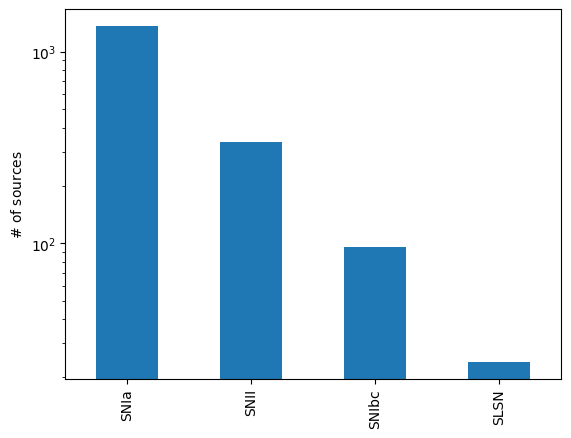

In [486]:
#plotting the number of sources per class for the labeled set
class_counts = Counter(labels['class_original'])
class_counts.most_common()
print(class_counts)


df_hist = pd.DataFrame.from_dict(class_counts, orient='index',columns=['number'])
df_hist = df_hist.sort_values(by=['number'],ascending=False)
print(df_hist)
df_hist.plot(kind='bar',legend=False)


plt.yscale('log')

plt.ylabel(r'$\#$ of sources')

plt.savefig('number_sources_labeled_set.pdf',bbox_inches='tight')

In [487]:
def plot_confusion_matrix(cm, classes, plot_name,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = np.round((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])*100)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    print(cm)

    fig, ax = plt.subplots(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize = 17)
    plt.yticks(tick_marks, classes, fontsize = 17)

    #fmt = '.2f' if normalize else 'd'
    fmt =  'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%d"%  (cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",fontsize = 16)

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 18)
    plt.xlabel('Predicted label',fontsize = 18)
    plt.savefig(plot_name, bbox_inches='tight')
    #plt.close()



def plot_feature_importances(model, feature_names,feature_importances_name):
    I = np.argsort(model.feature_importances_)[::-1]
    I = I[0:60]
    for i in I[0:30]:
        print(feature_names[i], "& %.3f" % (model.feature_importances_[i]))
    fig, ax = plt.subplots(figsize=(16, 5), tight_layout=True)
    x_plot = np.arange(len(I))
    plt.xticks(x_plot, [feature_names[i] for i in I], rotation='vertical')
    ax.bar(x_plot, height=model.feature_importances_[I]);
    plt.savefig(feature_importances_name, bbox_inches='tight')
    #plt.close()

### RF

In [488]:
Y_hierarchical = labels['class_hierachical']
Y_original = labels['class_original']

print(len(labels['class_hierachical'].values))
print(len(labels['class_original'].values))
X_hierarchical = df

#splitting training set
X_train_hierarchical, X_test_hierarchical, y_train_hierarchical, y_test_hierarchical, y_train_original, y_test_original  = model_selection.train_test_split(X_hierarchical,
          Y_hierarchical, Y_original, test_size=0.2, stratify=Y_original)


# separating training sets for sub-classes
X_train_periodic = X_train_hierarchical.loc[y_train_hierarchical=='Periodic', :]
y_train_periodic = y_train_original.loc[y_train_hierarchical=='Periodic']

X_train_stochastic = X_train_hierarchical.loc[y_train_hierarchical=='Stochastic', :]
y_train_stochastic = y_train_original.loc[y_train_hierarchical=='Stochastic']

X_train_transient = X_train_hierarchical.loc[y_train_hierarchical=='Transient', :]
y_train_transient = y_train_original.loc[y_train_hierarchical=='Transient']

X_test_periodic = X_test_hierarchical
X_test_stochastic = X_test_hierarchical
X_test_transient = X_test_hierarchical

print(len(y_train_periodic), len(y_train_stochastic), len(y_train_transient))

1823
1823
0 0 1458


In [489]:
import os
import numpy as np

# Crear la carpeta si no existe
os.makedirs('final_BHRF_model', exist_ok=True)

# Guardar los índices
np.save('final_BHRF_model/labels_training_sample.npy', X_train_hierarchical.index.values)
np.save('final_BHRF_model/labels_testint_sample.npy', X_test_hierarchical.index.values)

In [490]:
model_transient_layer = 'rf_model_transient.pkl'  # Nombre del archivo para el modelo
features_pickle = 'features_transient.pkl'  # Nombre del archivo para las características

rf_model_transient = RandomForestClassifier(
            n_estimators=500,
            max_features='sqrt',
            max_depth=None,
            n_jobs=-1,
            bootstrap=True,
            class_weight='balanced_subsample',
            criterion='entropy',
            min_samples_split=2,
            min_samples_leaf=1)

rf_model_transient.fit(X_train_transient, y_train_transient)

# Applying transient model to the test data
y_true_transient, y_pred_transient  = y_test_original, rf_model_transient.predict(X_test_transient)
y_pred_proba_transient = rf_model_transient.predict_proba(X_test_transient)

classes_order_proba_transient = rf_model_transient.classes_
print(classes_order_proba_transient)

#Dumping trained model

features_transient = list(X_train_transient)

with open(model_transient_layer, 'wb') as f:
            pickle.dump(
                rf_model_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

with open(features_pickle, 'wb') as f:
            pickle.dump(
                features_transient,
                f,
                pickle.HIGHEST_PROTOCOL)

c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
c:\Users\juans\AppData\Local\Programs\Python\Python39\lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(


['SLSN' 'SNII' 'SNIa' 'SNIbc']


#### RF: confusion_matrix

SPM_gamma_r & 0.025
SPM_t0_g & 0.023
MHPS_ratio_g & 0.023
SPM_tau_rise_r & 0.023
first_mag_r & 0.020
LinearTrend_r & 0.019
SPM_t0_r & 0.019
g-r_max_g_r & 0.017
g-r_mean_g_r & 0.015
SPM_gamma_g & 0.014
IAR_phi_r & 0.013
Period_band_g & 0.013
delta_mjd_fid_g & 0.013
delta_mjd_fid_r & 0.013
AndersonDarling_r & 0.013
SPM_tau_fall_g & 0.011
MHPS_high_g & 0.011
SPM_tau_rise_g & 0.011
dmag_first_det_fid_g & 0.011
Skew_r & 0.010
first_mag_g & 0.010
Gskew_r & 0.009
SPM_beta_g & 0.009
MHPS_ratio_r & 0.009
SPM_tau_fall_r & 0.009
Psi_CS_r & 0.008
SPM_beta_r & 0.008
LinearTrend_g & 0.008
sgscore1 & 0.008
GP_DRW_tau_r & 0.008


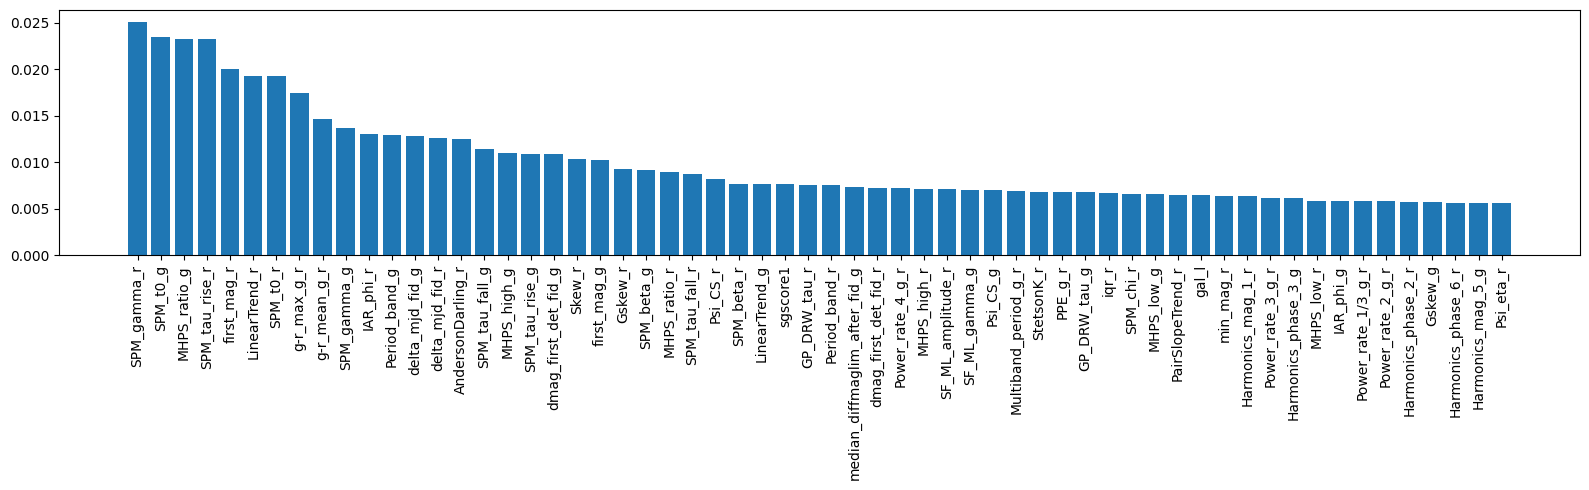

In [491]:
plot_feature_importances(rf_model_transient, features_transient, 'final_BHRF_model/feature_ranking_transient_level.pdf')

In [492]:
# Clases de interés
selected_classes = ['SLSN', 'SNII', 'SNIa', 'SNIbc']

# Filtrar las etiquetas verdaderas y predicciones para estas clases
mask = y_true_transient.isin(selected_classes)
y_true_selected = y_true_transient[mask]
y_pred_selected = y_pred_transient[mask]

Accuracy: 0.72
Balanced accuracy: 0.71
Macro precision: 0.51
Macro recall: 0.71
Macro F1: 0.51
              precision    recall  f1-score   support

        SLSN       0.21      1.00      0.34         5
        SNII       0.73      0.54      0.62        68
        SNIa       0.93      0.77      0.84       273
       SNIbc       0.15      0.53      0.24        19

    accuracy                           0.72       365
   macro avg       0.51      0.71      0.51       365
weighted avg       0.84      0.72      0.76       365

Matriz de confusión normalizada


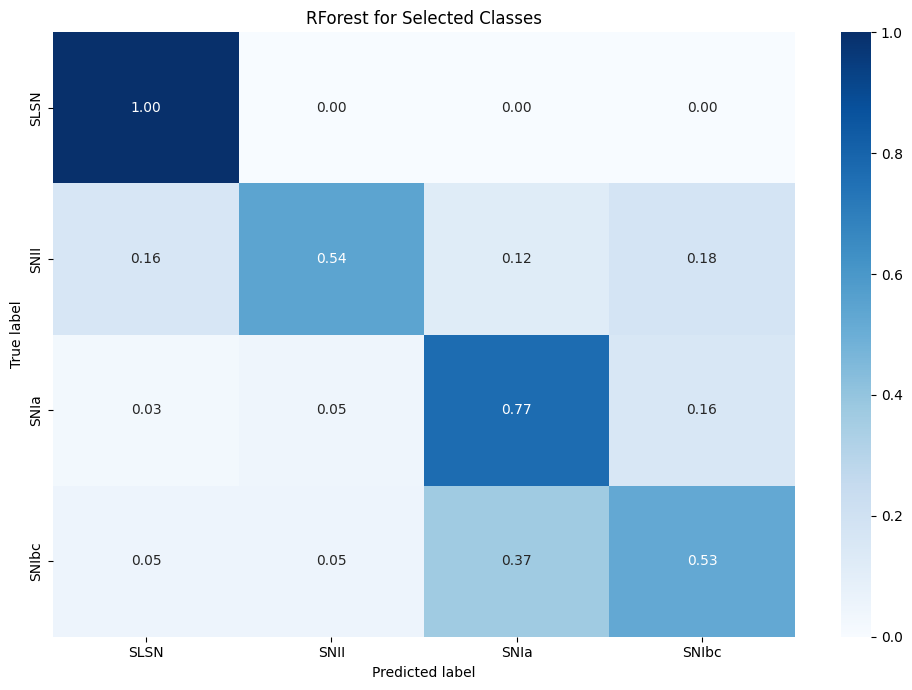

In [493]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report

# Calcular las métricas globales
accuracy = accuracy_score(y_true_selected, y_pred_selected)
balanced_accuracy = balanced_accuracy_score(y_true_selected, y_pred_selected)
macro_precision = precision_score(y_true_selected, y_pred_selected, average='macro')
macro_recall = recall_score(y_true_selected, y_pred_selected, average='macro')
macro_f1 = f1_score(y_true_selected, y_pred_selected, average='macro')

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
report = classification_report(y_true_selected, y_pred_selected, target_names=selected_classes)
print(report)

# Matriz de confusión y otras visualizaciones
cm_selected = confusion_matrix(y_true_selected, y_pred_selected, labels=selected_classes)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='rf_confusion_matrix.pdf', normalize=True, title='Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()
    
plot_confusion_matrix(cm_selected, classes=selected_classes, plot_name='rf_confusion_matrix_selected_classes.pdf',
                      normalize=True, title='RForest for Selected Classes')


### MLP 1

In [494]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
import numpy as np

# y_train_transient y y_test_original son categóricos
label_encoder = LabelEncoder()  # Convertir a numéricos
y_train_encoded = label_encoder.fit_transform(y_train_transient)
y_test_encoded = label_encoder.transform(y_test_original)

# Escalando los datos de entrada N(0,1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_transient)
X_test_scaled = scaler.transform(X_test_transient)

# Aplicar SMOTE a los datos de entrenamiento
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train_encoded)

# Convertir los datos de entrada escalados a tensores para PyTorch
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

# Convertir las etiquetas a tensores para PyTorch
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

Ahora etiquetas y vectores de entrada son tensores PyTorch ↑↑↑

In [495]:
# Definir la clase del modelo MLP
class MLPModel(nn.Module):  # Modelo en PyTorch
    def __init__(self):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(X_train_scaled.shape[1], 100)  # Primera capa densa (lineal)
        # Produce 100 neuronas como salida
        self.fc2 = nn.Linear(100, 50)  # Produce 50 neuronas como salida
        self.fc3 = nn.Linear(50, len(torch.unique(y_train_tensor)))  # Produce una salida del 
        # tamaño igual al número de clases en las etiquetas

    def forward(self, x):  # Se introducen no linealidades
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # No tiene activación
        return x

# Inicializar el modelo
model = MLPModel()

# Calcular pesos de clase
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # En un problema de clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Optimizador Adam con tasa de aprendizaje de 0.0001

In [496]:
# Bucle de entrenamiento
num_epochs = 220
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Imprimir las pérdidas finales
print(f"Entrenamiento finalizado. Pérdida de entrenamiento: {train_losses[-1]:.4f}, Pérdida de validación: {val_losses[-1]:.4f}")

Epoch [10/220], Loss: 1.3785, Val Loss: 1.3699
Epoch [20/220], Loss: 1.3625, Val Loss: 1.3607
Epoch [30/220], Loss: 1.3478, Val Loss: 1.3521
Epoch [40/220], Loss: 1.3335, Val Loss: 1.3441
Epoch [50/220], Loss: 1.3200, Val Loss: 1.3360
Epoch [60/220], Loss: 1.3069, Val Loss: 1.3278
Epoch [70/220], Loss: 1.2938, Val Loss: 1.3201
Epoch [80/220], Loss: 1.2806, Val Loss: 1.3136
Epoch [90/220], Loss: 1.2672, Val Loss: 1.3078
Epoch [100/220], Loss: 1.2535, Val Loss: 1.3014
Epoch [110/220], Loss: 1.2395, Val Loss: 1.2942
Epoch [120/220], Loss: 1.2248, Val Loss: 1.2859
Epoch [130/220], Loss: 1.2095, Val Loss: 1.2768
Epoch [140/220], Loss: 1.1933, Val Loss: 1.2674
Epoch [150/220], Loss: 1.1765, Val Loss: 1.2563
Epoch [160/220], Loss: 1.1591, Val Loss: 1.2452
Epoch [170/220], Loss: 1.1411, Val Loss: 1.2341
Epoch [180/220], Loss: 1.1225, Val Loss: 1.2217
Epoch [190/220], Loss: 1.1036, Val Loss: 1.2094
Epoch [200/220], Loss: 1.0846, Val Loss: 1.1979
Epoch [210/220], Loss: 1.0658, Val Loss: 1.1874
E

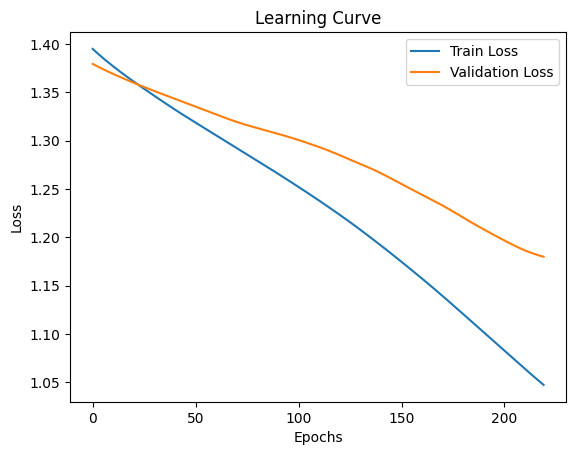

In [497]:
# Graficar la curva de aprendizaje
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

Accuracy: 0.49
Balanced accuracy: 0.37
Macro precision: 0.32
Macro recall: 0.37
Macro F1: 0.29
              precision    recall  f1-score   support

        SLSN       0.04      0.40      0.08         5
        SNII       0.36      0.37      0.36        68
        SNIa       0.82      0.55      0.66       273
       SNIbc       0.04      0.16      0.07        19

    accuracy                           0.49       365
   macro avg       0.32      0.37      0.29       365
weighted avg       0.69      0.49      0.57       365

Matriz de confusión normalizada


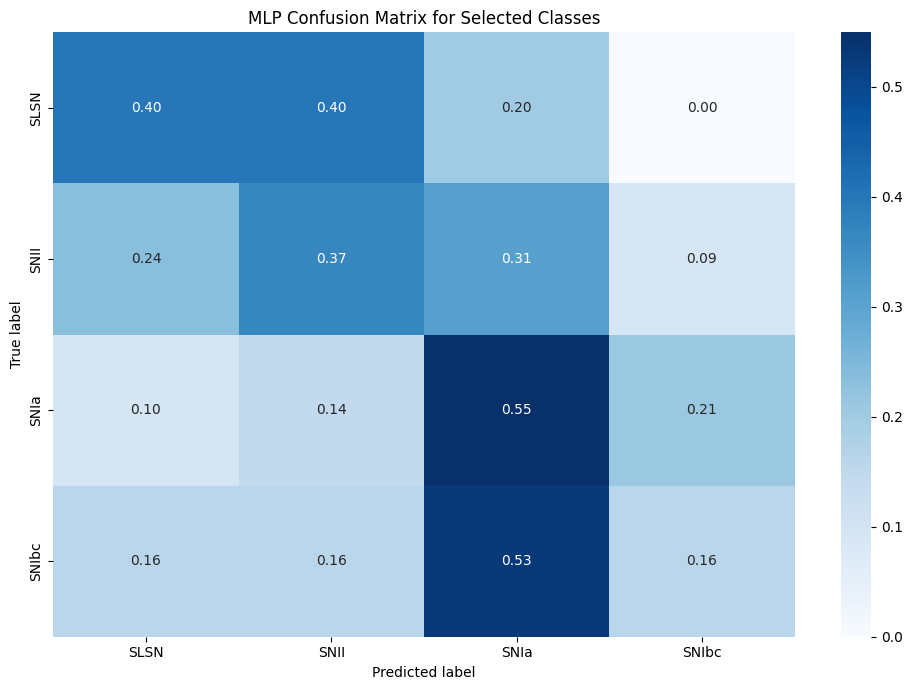

In [498]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Realizar predicciones sobre el conjunto de prueba
model.eval()  # Colocar el modelo en modo evaluación
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Obtener las predicciones
    _, y_pred_tensor = torch.max(test_outputs, 1)  # Convertir probabilidades en clases

# Convertir los tensores a numpy arrays para las métricas de sklearn
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

# Calcular las métricas globales
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
selected_classes = label_encoder.classes_  # Obtener los nombres de las clases originales
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='mlp_confusion_matrix.pdf', normalize=True, title='MLP Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, classes=selected_classes, plot_name='mlp_confusion_matrix_selected_classes.pdf',
                      normalize=True, title='MLP Confusion Matrix for Selected Classes')


#### MLP: Exportar

In [499]:
# Guardar el modelo en formato .pth
model_path = 'mlp_model_transient.pth'
torch.save(model.state_dict(), model_path)
print(f'Modelo guardado en: {model_path}')

Modelo guardado en: mlp_model_transient.pth


In [500]:
# Guardar los parámetros entrenados en trained_parameters.pth
torch.save(model.state_dict(), 'trained_parameters.pth')
print('Parámetros entrenados guardados en: trained_parameters.pth')

Parámetros entrenados guardados en: trained_parameters.pth


### MLP: Multi-classSVDD

In [501]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Supongo que el número de clases es el mismo que en tu MLPModel, es decir, len(torch.unique(y_train_tensor))

class classvdd(nn.Module):
    """Pytorch implementation of an autoencoder based on MLP."""

    def __init__(self, input_dim, z_dim, num_classes):
        super(classvdd, self).__init__()
        # Encoder Architecture
        self.enc1 = nn.Linear(input_dim, 512)
        self.encbn1 = nn.BatchNorm1d(512)
        self.enc2 = nn.Linear(512, 256)
        self.encbn2 = nn.BatchNorm1d(256)
        self.enc3 = nn.Linear(256, 128)
        self.encbn3 = nn.BatchNorm1d(128)
        self.enc4 = nn.Linear(128, z_dim, bias=False)
        self.fc_out = nn.Linear(z_dim, num_classes)  # Capa de salida para clasificación

    def encode(self, x):
        h = F.leaky_relu(self.encbn1(self.enc1(x)))
        h = F.leaky_relu(self.encbn2(self.enc2(h)))
        h = F.leaky_relu(self.encbn3(self.enc3(h)))
        return self.enc4(h)
    
    def forward(self, x):
        """Forward pass"""
        z = self.encode(x)
        out = self.fc_out(z)  # Usar salida de clasificación
        return out

    def compute_loss(self, outputs, labels):
        criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = criterion(outputs, labels)
        return loss

# Definir el número de características de entrada (dimensiones) y latente (z_dim)
input_dim = X_train_scaled.shape[1]  # Número de características de entrada
z_dim = 64  # Puedes ajustar este valor según sea necesario
num_classes = len(torch.unique(y_train_tensor))  # Número de clases

# Inicializar el modelo
model = classvdd(input_dim=input_dim, z_dim=z_dim, num_classes=num_classes)

# Definir el optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Bucle de entrenamiento
num_epochs = 220
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train_tensor)
    loss = model.compute_loss(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validación
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = model.compute_loss(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())
    
    # Imprimir cada 10 épocas
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Evaluar el modelo con precisión
with torch.no_grad():
    y_pred = torch.argmax(model(X_test_tensor), dim=1)
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f'Precisión en el conjunto de prueba: {accuracy:.4f}')


Epoch [10/220], Loss: 1.2183, Val Loss: 1.4285
Epoch [20/220], Loss: 1.0850, Val Loss: 1.3806
Epoch [30/220], Loss: 0.9684, Val Loss: 1.2938
Epoch [40/220], Loss: 0.8649, Val Loss: 1.1943
Epoch [50/220], Loss: 0.7681, Val Loss: 1.1019
Epoch [60/220], Loss: 0.6743, Val Loss: 1.0158
Epoch [70/220], Loss: 0.5839, Val Loss: 0.9229
Epoch [80/220], Loss: 0.4974, Val Loss: 0.8407
Epoch [90/220], Loss: 0.4168, Val Loss: 0.7682
Epoch [100/220], Loss: 0.3442, Val Loss: 0.7207
Epoch [110/220], Loss: 0.2802, Val Loss: 0.6991
Epoch [120/220], Loss: 0.2260, Val Loss: 0.6897
Epoch [130/220], Loss: 0.1809, Val Loss: 0.6923
Epoch [140/220], Loss: 0.1448, Val Loss: 0.7062
Epoch [150/220], Loss: 0.1163, Val Loss: 0.7265
Epoch [160/220], Loss: 0.0933, Val Loss: 0.7450
Epoch [170/220], Loss: 0.0755, Val Loss: 0.7627
Epoch [180/220], Loss: 0.0613, Val Loss: 0.7796
Epoch [190/220], Loss: 0.0503, Val Loss: 0.7986
Epoch [200/220], Loss: 0.0418, Val Loss: 0.8166
Epoch [210/220], Loss: 0.0349, Val Loss: 0.8381
E

Accuracy: 0.78
Balanced accuracy: 0.37
Macro precision: 0.37
Macro recall: 0.37
Macro F1: 0.37
              precision    recall  f1-score   support

        SLSN       0.00      0.00      0.00         5
        SNII       0.61      0.57      0.59        68
        SNIa       0.86      0.89      0.88       273
       SNIbc       0.00      0.00      0.00        19

    accuracy                           0.78       365
   macro avg       0.37      0.37      0.37       365
weighted avg       0.76      0.78      0.77       365

Matriz de confusión normalizada


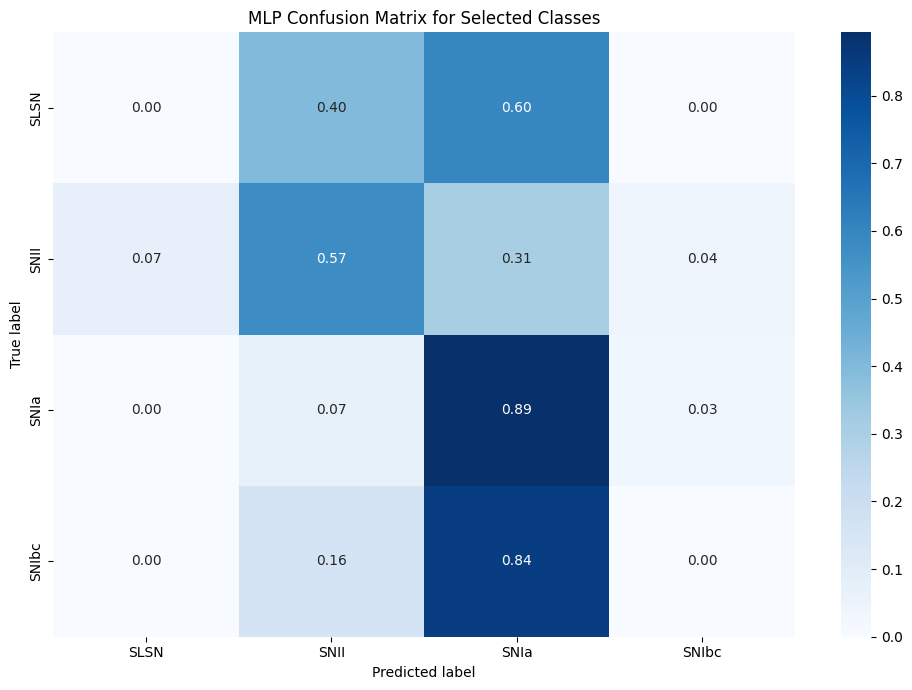

In [502]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Realizar predicciones sobre el conjunto de prueba
model.eval()  # Colocar el modelo en modo evaluación
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Obtener las predicciones
    _, y_pred_tensor = torch.max(test_outputs, 1)  # Convertir probabilidades en clases

# Convertir los tensores a numpy arrays para las métricas de sklearn
y_pred = y_pred_tensor.cpu().numpy()
y_true = y_test_tensor.cpu().numpy()

# Calcular las métricas globales
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Generar el reporte detallado por clase
selected_classes = label_encoder.classes_  # Obtener los nombres de las clases originales
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='mlp_confusion_matrix.pdf', normalize=True, title='MLP Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, classes=selected_classes, plot_name='mlp_confusion_matrix_selected_classes.pdf',
                      normalize=True, title='MLP Confusion Matrix for Selected Classes')


#### MLP: Exportar

In [503]:
# Después de finalizar el entrenamiento

# Guardar el modelo en formato .pth
model_path = 'SVDDmlp.pth'
torch.save(model.state_dict(), model_path)
print(f'Modelo guardado en: {model_path}')

Modelo guardado en: SVDDmlp.pth


### Evaluar

#### Evaluar: MLP vs. MLP_VDD

In [504]:
# Inicializar el modelo
model = MLPModel()

# Cargar los parámetros entrenados
model.load_state_dict(torch.load('mlp_model_transient.pth'))
model.eval()

# Evaluar el modelo en el conjunto de prueba
with torch.no_grad():
    predicted = model(X_test_tensor)
    predicted_classes = torch.max(predicted, 1)[1]
    accuracy = accuracy_score(y_test_tensor.numpy(), predicted_classes.numpy())
    print(f'Accuracy en datos de prueba: {accuracy * 100:.2f}%')


Accuracy en datos de prueba: 49.32%


C:\Users\juans\AppData\Local\Temp\ipykernel_17128\3816431611.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('mlp_model_transient.pth'))

In [505]:
# Inicializar el modelo con los argumentos correctos
input_dim = X_train_scaled.shape[1]  # Número de características de entrada
z_dim = 64  # Puedes ajustar este valor según lo que usaste al entrenar el modelo
num_classes = len(torch.unique(y_train_tensor))  # Número de clases

# Inicializar el modelo con las dimensiones correctas
model = classvdd(input_dim=input_dim, z_dim=z_dim, num_classes=num_classes)

# Cargar los parámetros entrenados
model.load_state_dict(torch.load('SVDDmlp.pth'))
model.eval()  # Colocar el modelo en modo de evaluación

# Evaluar el modelo en el conjunto de prueba
with torch.no_grad():
    predicted = model(X_test_tensor)  # Realizar predicciones sobre los datos de prueba
    predicted_classes = torch.max(predicted, 1)[1]  # Convertir las probabilidades en clases predichas
    accuracy = accuracy_score(y_test_tensor.numpy(), predicted_classes.numpy())  # Calcular la precisión
    print(f'Accuracy en datos de prueba: {accuracy * 100:.2f}%')  # Mostrar la precisión como porcentaje


Accuracy en datos de prueba: 77.53%


C:\Users\juans\AppData\Local\Temp\ipykernel_17128\4205838145.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('SVDDmlp.pth'))


#### Gráficos MLP: Multi-classSVDD

C:\Users\juans\AppData\Local\Temp\ipykernel_17128\1696963732.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('SVDDmlp.pth'))
c:\Users\ju

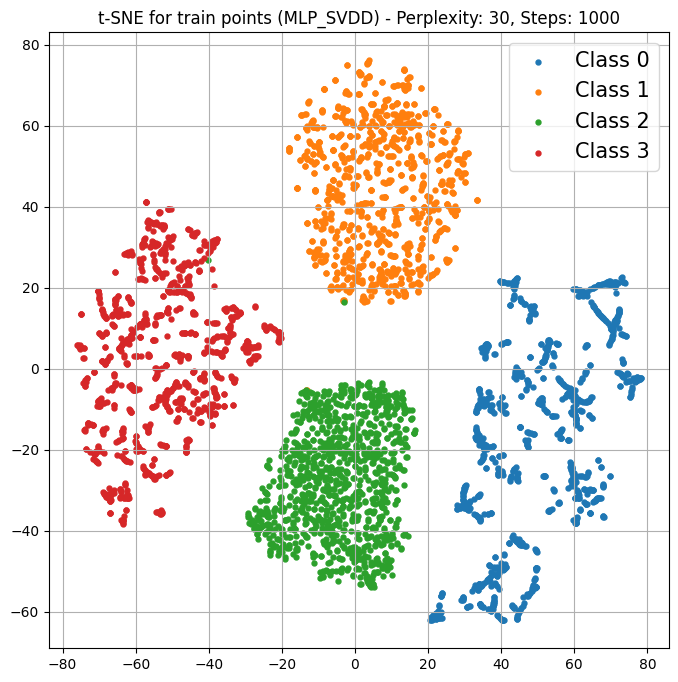

In [506]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model = classvdd(input_dim=input_dim, z_dim=z_dim, num_classes=num_classes)

# Cargar el modelo entrenado
model.load_state_dict(torch.load('SVDDmlp.pth'))
model.eval()  # Colocar el modelo en modo de evaluación

# Extraer el espacio latente directamente de los tensores de entrenamiento
with torch.no_grad():
    latents_train = model.encode(X_train_tensor)  # Extraer el espacio latente directamente del modelo
    labels_train = y_train_tensor  # Usar las etiquetas correspondientes a X_train_tensor

# Convertir tensores a numpy para t-SNE
latents_train_np = latents_train.numpy()
labels_train_np = labels_train.numpy()

# Ajustar perplejidad y número de iteraciones (steps)
perplexity = 30  # Ajusta este valor según el tamaño del dataset (valores típicos: 5 a 50)
n_iter = 1000  # Número de iteraciones (steps), puedes ajustarlo (valores típicos: 250 a 1000)

# Aplicar t-SNE con los nuevos parámetros
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter)
latents_2d = tsne.fit_transform(latents_train_np)

# Visualización de los puntos t-SNE
plt.figure(figsize=(8, 8))
plt.title(f't-SNE for train points (MLP_SVDD) - Perplexity: {perplexity}, Steps: {n_iter}')

# Colores para cada clase
for key in range(len(np.unique(labels_train_np))):
    plt.scatter(latents_2d[:, 0][labels_train_np == key], 
                latents_2d[:, 1][labels_train_np == key], 
                s=50, alpha=1, marker='.', label=f'Class {key}')

plt.legend(fontsize=15)
plt.grid(True)
plt.show()



### Multi-classSVDD (ahora con distancias)

A diferencia de la última MLP (MLP: Multi-classSVDD) esta red está diseñada para una tarea de determinación de anomalías. Utiliza una representación en un espacio latente (z_dim), y su enfoque principal es calcular la distancia de cada punto a los centros de clase (set_c). Esto es típico de un modelo SVDD (Support Vector Data Description) para detectar anomalías o datos fuera de lo común.

In [546]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

class MulticlassSVDD(nn.Module):
    def __init__(self, input_dim, z_dim):
        super(MulticlassSVDD, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, z_dim, bias=False)

    def encode(self, x):
        h = F.leaky_relu(self.bn1(self.fc1(x)))
        h = F.leaky_relu(self.bn2(self.fc2(h)))
        h = F.leaky_relu(self.bn3(self.fc3(h)))
        return self.fc4(h)

    def forward(self, x):
        return self.encode(x)
    
    def set_c(self, dataloader, eps=0.01):
        """Inicializa el centro para la hiperesfera de cada clase"""
        latents, labels = self.get_latent_space(dataloader)
        c = []
        for i in range(len(np.unique(labels))):
            ixs = np.where(labels == i)
            c.append(torch.mean(latents[ixs], dim=0))
        c = torch.stack(c)
        for i in range(len(c)):
            c[i][(abs(c[i]) < eps) & (c[i] < 0)] = -eps
            c[i][(abs(c[i]) < eps) & (c[i] > 0)] = eps
        self.c = c.to(next(self.parameters()).device)  # Asigna al mismo dispositivo del modelo
    
    def get_latent_space(self, dataloader):
        """Obtiene el espacio latente y etiquetas del dataloader para inicialización"""
        latents = []
        labels = []
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(next(self.parameters()).device).float(), y.long()
                z = self.forward(x)
                latents.append(z.detach().cpu())
                labels.append(y)
        return torch.cat(latents), torch.cat(labels)
        
    def compute_loss(self, x, y):
        """
        Compute MSE Loss.
        """
        z = self.forward(x)
        self.loss = torch.mean(torch.sum((z - self.c[y]) ** 2, dim=1))
        return self.loss
    
    def compute_anomaly_score(self, x):
        """Calcula el puntaje de anomalía para cada muestra"""
        z = self.forward(x)
        score = torch.min(torch.sum((z.unsqueeze(1) - self.c) ** 2, dim=2), dim=1)[0]
        return score

# Inicialización del modelo
input_dim = X_train_scaled.shape[1]  # Dimensión de entrada basada en tus datos
z_dim = 64  # Definir un espacio latente más grande para mejorar la representación
model = MulticlassSVDD(input_dim, z_dim)

# Definir el optimizador con weight_decay para regularización L2
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Dataloader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

# Inicializar el centro de las clases usando los datos de entrenamiento
model.set_c(train_loader)

# Bucle de entrenamiento
num_epochs = 1500
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    loss = model.compute_loss(X_train_tensor, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # Validación
    model.eval()
    with torch.no_grad():
        val_loss = model.compute_loss(X_test_tensor, y_test_tensor)
        val_losses.append(val_loss.item())
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

# Calcular puntajes de anomalía en el conjunto de prueba
model.eval()
with torch.no_grad():
    anomaly_scores = model.compute_anomaly_score(X_test_tensor)

Epoch [10/1500], Loss: 0.5322, Val Loss: 2.5210
Epoch [20/1500], Loss: 0.2488, Val Loss: 0.6301
Epoch [30/1500], Loss: 0.1651, Val Loss: 0.2897
Epoch [40/1500], Loss: 0.1304, Val Loss: 0.1852
Epoch [50/1500], Loss: 0.1116, Val Loss: 0.1490
Epoch [60/1500], Loss: 0.0989, Val Loss: 0.1339
Epoch [70/1500], Loss: 0.0897, Val Loss: 0.1247
Epoch [80/1500], Loss: 0.0825, Val Loss: 0.1195
Epoch [90/1500], Loss: 0.0767, Val Loss: 0.1159
Epoch [100/1500], Loss: 0.0718, Val Loss: 0.1129
Epoch [110/1500], Loss: 0.0676, Val Loss: 0.1107
Epoch [120/1500], Loss: 0.0640, Val Loss: 0.1090
Epoch [130/1500], Loss: 0.0607, Val Loss: 0.1072
Epoch [140/1500], Loss: 0.0576, Val Loss: 0.1056
Epoch [150/1500], Loss: 0.0547, Val Loss: 0.1046
Epoch [160/1500], Loss: 0.0519, Val Loss: 0.1030
Epoch [170/1500], Loss: 0.0492, Val Loss: 0.1002
Epoch [180/1500], Loss: 0.0466, Val Loss: 0.0987
Epoch [190/1500], Loss: 0.0441, Val Loss: 0.0984
Epoch [200/1500], Loss: 0.0418, Val Loss: 0.0973
Epoch [210/1500], Loss: 0.039

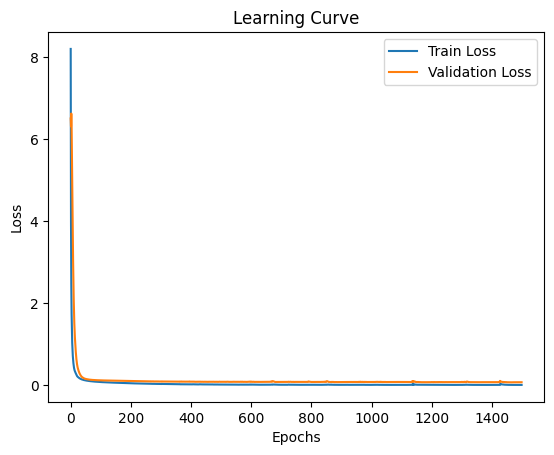

In [547]:
# Graficar la curva de aprendizaje
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

In [548]:
# Después de finalizar el entrenamiento

# Guardar el modelo en formato .pth
model_path = 'Multi-classSVDD.pth'
torch.save(model.state_dict(), model_path)
print(f'Modelo guardado en: {model_path}')

Modelo guardado en: Multi-classSVDD.pth


In [552]:
# --- Evaluación de detección de outliers ---

# Calcular puntajes de anomalía en el conjunto de prueba
model.eval()
with torch.no_grad():
    anomaly_scores = model.compute_anomaly_score(X_test_tensor)

# Definir un umbral para detectar outliers (percentil 95)
threshold = np.percentile(anomaly_scores.cpu().numpy(), 10)

# Clasificar las muestras como "outliers" si su puntaje de anomalía excede el umbral
y_pred_outliers = (anomaly_scores.cpu().numpy() > threshold).astype(int)  # 1 para outliers, 0 para normales

# Usamos y_test_tensor para identificar inliers y outliers en el test set
y_true_outliers = (y_test_tensor == 1).cpu().numpy()  # Suponiendo que 1 es outlier

# Calcular las métricas de clasificación
precision = precision_score(y_true_outliers, y_pred_outliers)
recall = recall_score(y_true_outliers, y_pred_outliers)
f1 = f1_score(y_true_outliers, y_pred_outliers)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_true_outliers, y_pred_outliers)
print("Matriz de confusión:\n", cm)

Precision: 0.2043
Recall: 0.9853
F1 Score: 0.3384
Matriz de confusión:
 [[ 36 261]
 [  1  67]]


Accuracy: 0.80
Balanced accuracy: 0.53
Macro precision: 0.60
Macro recall: 0.53
Macro F1: 0.52
              precision    recall  f1-score   support

      Inlier       0.82      0.96      0.89       297
     Outlier       0.37      0.10      0.16        68

    accuracy                           0.80       365
   macro avg       0.60      0.53      0.52       365
weighted avg       0.74      0.80      0.75       365

Matriz de confusión normalizada


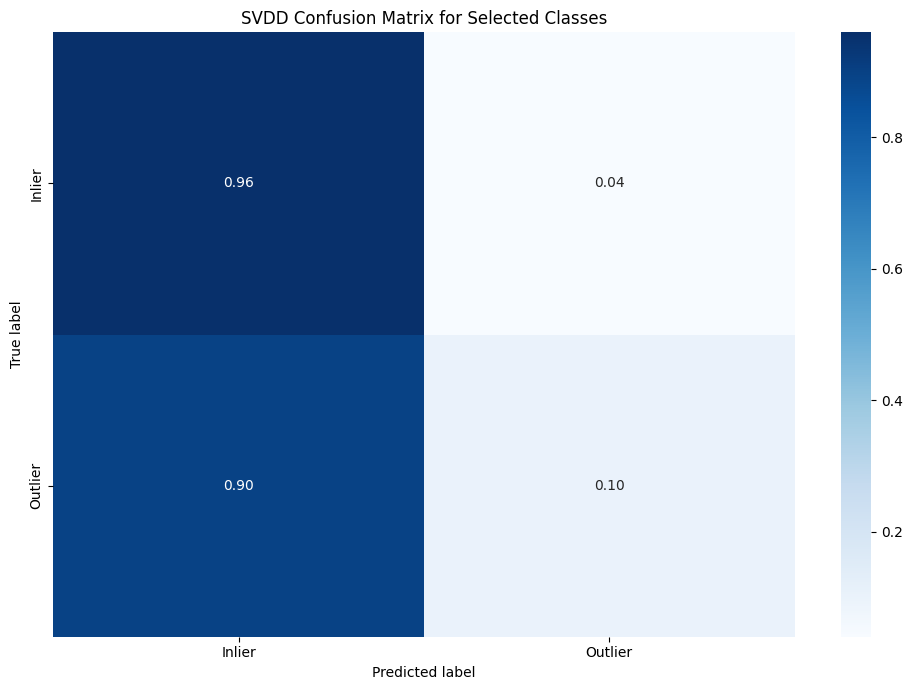

In [553]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Realizar predicciones sobre el conjunto de prueba
model.eval()  # Colocar el modelo en modo evaluación
with torch.no_grad():
    test_outputs = model(X_test_tensor)  # Obtener las predicciones
    anomaly_scores = model.compute_anomaly_score(X_test_tensor)  # Calcular puntajes de anomalía

# Definir un umbral para detectar outliers (percentil 95)
threshold = np.percentile(anomaly_scores.cpu().numpy(), 95)

# Clasificar las muestras como "outliers" si su puntaje de anomalía excede el umbral
y_pred_tensor = (anomaly_scores.cpu().numpy() > threshold).astype(int)  # 1 para outliers, 0 para inliers

# Convertir los tensores a numpy arrays para las métricas de sklearn
y_pred = y_pred_tensor
y_true = (y_test_tensor == 1).cpu().numpy()  # Suponiendo que 1 es outlier

# Calcular las métricas globales
accuracy = accuracy_score(y_true, y_pred)
balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
macro_precision = precision_score(y_true, y_pred, average='macro', zero_division=1)
macro_recall = recall_score(y_true, y_pred, average='macro', zero_division=1)
macro_f1 = f1_score(y_true, y_pred, average='macro', zero_division=1)

# Imprimir las métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Balanced accuracy: {balanced_accuracy:.2f}")
print(f"Macro precision: {macro_precision:.2f}")
print(f"Macro recall: {macro_recall:.2f}")
print(f"Macro F1: {macro_f1:.2f}")

# Nombres de las clases
selected_classes = ['Inlier', 'Outlier']  # Etiquetas de clases

# Generar el reporte detallado por clase
report = classification_report(y_true, y_pred, target_names=selected_classes)
print(report)

# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)

# Función para graficar la matriz de confusión
def plot_confusion_matrix(cm, classes, plot_name='svdd_confusion_matrix.pdf', normalize=True, title='SVDD Confusion Matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print("Matriz de confusión sin normalizar")

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(plot_name)
    plt.show()

# Graficar la matriz de confusión
plot_confusion_matrix(cm, classes=selected_classes, plot_name='svdd_confusion_matrix_selected_classes.pdf',
                      normalize=True, title='SVDD Confusion Matrix for Selected Classes')


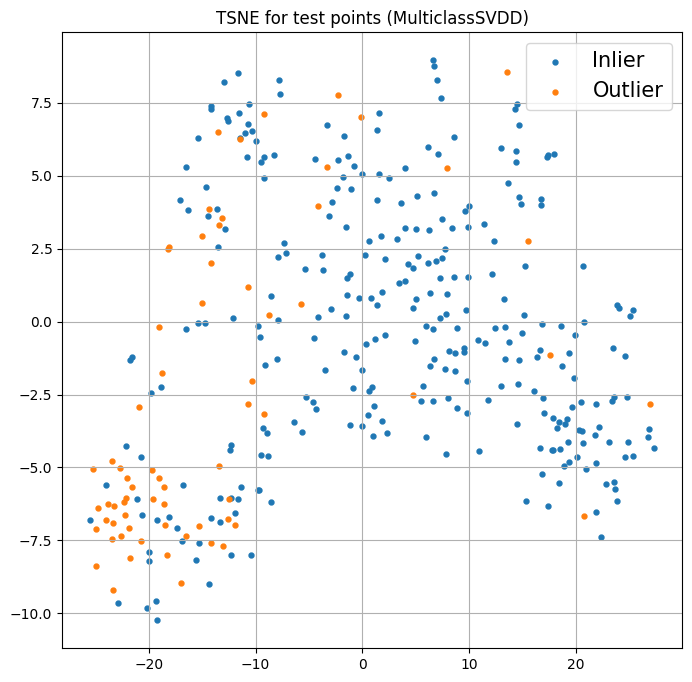

In [554]:
# --- Visualización t-SNE ---

# Obtener espacio latente para aplicar t-SNE
with torch.no_grad():
    z_test = model.encode(X_test_tensor).cpu().numpy()

# Aplicar t-SNE para reducir dimensionalidad a 2D
x_embedded = TSNE(n_components=2).fit_transform(z_test)

# Visualizar usando t-SNE
dict_classes = {
    0: 'Inlier',
    1: 'Outlier',
}

plt.figure(figsize=(8,8))
plt.title('TSNE for test points (MulticlassSVDD)')
for key in np.unique(y_true_outliers):
    plt.scatter(
        x_embedded[:, 0][y_true_outliers == key], 
        x_embedded[:, 1][y_true_outliers == key], 
        s=50, alpha=1, marker='.', label=dict_classes[key]
    )
plt.legend(fontsize=15)
plt.grid(True)
plt.show()

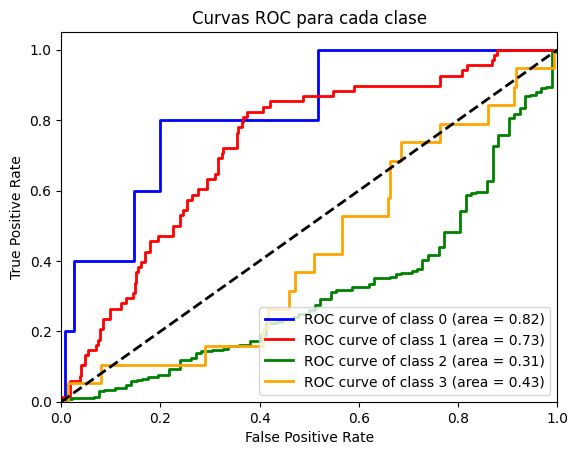

In [557]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Calcular ROC para cada clase individualmente
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    # Obtenemos las etiquetas binarizadas para la clase i (One-vs-Rest)
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], anomaly_scores)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC
plt.figure()
colors = cycle(['blue', 'red', 'green', 'orange'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Línea diagonal de referencia
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curvas ROC para cada clase')
plt.legend(loc="lower right")
plt.show()
